###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import minautograd
from minautograd import MLP, Variable

In [3]:
np.random.seed(1337)
random.seed(1337)

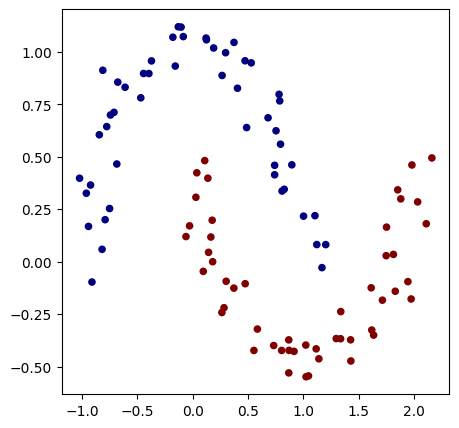

In [4]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2)], Layer of [TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16), TanhNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [6]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Variable, xrow)) for xrow in Xb]
    yb = [Variable(y) for y in yb]
    # forward the model to get scores
    scores = list(map(model, inputs))
    # svm "max-margin" loss
    losses = [minautograd.relu(minautograd.add(Variable(1), minautograd.mul(minautograd.mul(Variable(-1), yi), scorei))) for yi, scorei in zip(yb, scores)]
    data_loss = minautograd.div(minautograd.add(*losses), Variable(len(losses)))
    alpha = 1e-4
    reg_loss = Variable(alpha * sum((p.data*p.data for p in model.parameters())))
    total_loss = minautograd.add(data_loss, reg_loss)
    # also get accuracy
    accuracy = [(yi.data > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss(32)
print(total_loss, acc)

Variable (data: 0.8121899983114856, grad: 0) 0.75


In [7]:
# optimization
for k in range(200):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 0.2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8047240913088218, accuracy 76.0%
step 10 loss 0.3366700918733926, accuracy 87.0%
step 20 loss 0.30188243432682055, accuracy 87.0%
step 30 loss 0.29009941414471907, accuracy 87.0%
step 40 loss 0.280304757610423, accuracy 87.0%
step 50 loss 0.27004683878801367, accuracy 87.0%
step 60 loss 0.2675152942100713, accuracy 87.0%
step 70 loss 0.2588145763264519, accuracy 87.0%
step 80 loss 0.2510013298842414, accuracy 88.0%
step 90 loss 0.24665364335325185, accuracy 88.0%
step 100 loss 0.2381598334191424, accuracy 89.0%
step 110 loss 0.23232682371390515, accuracy 88.0%
step 120 loss 0.22488389629734815, accuracy 89.0%
step 130 loss 0.22201544761619837, accuracy 90.0%
step 140 loss 0.21322299779781678, accuracy 89.0%
step 150 loss 0.20669829451752447, accuracy 89.0%
step 160 loss 0.19990238071893635, accuracy 92.0%
step 170 loss 0.18607307755386057, accuracy 92.0%
step 180 loss 0.18724504141563852, accuracy 95.0%
step 190 loss 0.1668866103460365, accuracy 95.0%


(-1.548639298268643, 1.951360701731357)

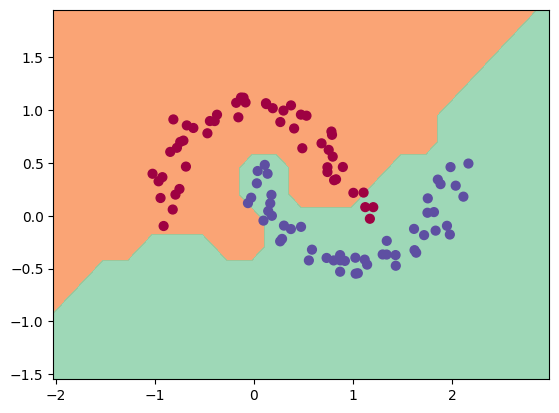

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Variable, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
